# Probability of default estimator 


In [42]:
#Downloading required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

## Data preprocessing

In [43]:
%%bash
gzip -dfk accepted_2007_to_2018Q4.csv.gz

In [44]:
accept = pd.read_csv('accepted_2007_to_2018Q4.csv')
for i in accept.columns:
    print(i)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
to

In [45]:
accept['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

We will consider dividing loans into 2 big groups:

Bad loans = 'Late (31-120)' (because it's high risk), 'Default' (by definition), 'Does not meet the credit policy. Status:Charged Off' (unreceivable loan), 'Charged off' (unreceivable loan)

Good loans = 'Fully Paid' and 'Does not meet the credit policy. Status:Fully Paid', because other types of loans have a potential to become a bad loan.

In [46]:
bad = ['Late (31-120 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Charged off']
good = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

df = accept[accept['loan_status'].isin(bad) | accept['loan_status'].isin(good)]

There is a possibility of uninformative data.
Firstly, let's drop columns with most NaNs. The threshold will be 25% of data.


Before that, let's check for duplicates.


In [47]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 0


Now we are ready to clean the data.

In [48]:
mask = (df.isnull().sum() / len(df)) * 100 < 25
filtered_columns = df.columns[mask]
df = df[filtered_columns]
df



,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260684,89846605,15000.0,15000.0,15000.0,36 months,10.49,487.47,B,B3,Billing clerk,...,50.0,0.0,0.0,297396.0,48654.0,78700.0,0.0,N,Cash,N
2260686,89867167,23800.0,23800.0,23800.0,60 months,14.49,559.85,C,C4,Exec Dir Internal Audit,...,100.0,0.0,0.0,406737.0,192571.0,61600.0,95737.0,N,Cash,N
2260688,89905081,18000.0,18000.0,18000.0,60 months,9.49,377.95,B,B2,NaN,...,33.3,0.0,0.0,275356.0,54349.0,13100.0,77756.0,N,Cash,N
2260690,88948836,29400.0,29400.0,29400.0,60 months,13.99,683.94,C,C3,Chief Operating Officer,...,42.9,0.0,0.0,719056.0,148305.0,56500.0,95702.0,N,Cash,N


93 columns may be too much and even excessive for future analysis. 

Let's get rid of potential multicolliniarity and useless columns.
I propose to drop id, 
issue_d, 
url, 
zip_code, 
funded_amnt, 
funded_amnt_inv, 
pymnt_plan, 
application_type, 
policy_code, 
out_prncp, 
out_prncp_inv, 
total_pymnt, 
total_pymnt_inv, 
total_rec_prncp, 
total_rec_int, 
total_rec_late_fee, 
recoveries, 
collection_recovery_fee, 
last_pymnt_d, 
last_pymnt_amnt, 
last_credit_pull_d, 
initial_list_status, 
total_bal_ex_mort, 
last_fico_range_low, 
last_fico_range_high, 
hardship_flag, 
purpose,
debt_settlement_flag, 
disbursement_method, 
mths_since_recent_inq,
mths_since_recent_bc,
mo_sin_old_il_acct,
mo_sin_old_rev_tl_op. 

These columns either show agent's characteristics after getting a loan or provoke multicolleniarity. 

In [49]:
columns_to_drop = [ 'id', 
    'issue_d', 'url', 'zip_code', 'funded_amnt', 'funded_amnt_inv', 
    'pymnt_plan', 'application_type', 'policy_code', 'out_prncp', 
    'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
    'last_credit_pull_d', 'initial_list_status', 'total_bal_ex_mort', 
    'last_fico_range_low', 'last_fico_range_high', 'hardship_flag', 'purpose',
    'debt_settlement_flag', 'disbursement_method', 'mths_since_recent_inq' , 'mths_since_recent_bc', 'mo_sin_old_il_acct',
'mo_sin_old_rev_tl_op'
]
df = df.drop(columns = columns_to_drop)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1101007.0,14176.489591,8696.902603,500.00,7500.00,12000.00,20000.00,40000.00
int_rate,1101007.0,12.685993,4.560143,5.31,9.17,12.29,15.31,30.99
installment,1101007.0,432.322541,261.420272,4.93,241.28,368.91,574.42,1719.83
annual_inc,1101003.0,77676.878450,71385.935776,0.00,47000.00,65000.00,93000.00,10999200.00
dti,1100680.0,17.848144,11.134097,-1.00,11.44,17.13,23.48,999.00
delinq_2yrs,1100978.0,0.310093,0.864194,0.00,0.00,0.00,0.00,39.00
fico_range_low,1101007.0,698.114794,32.773902,610.00,675.00,690.00,715.00,845.00
fico_range_high,1101007.0,702.114954,32.774621,614.00,679.00,694.00,719.00,850.00
inq_last_6mths,1100977.0,0.633302,0.943202,0.00,0.00,0.00,1.00,33.00
open_acc,1100978.0,11.515743,5.440993,0.00,8.00,11.00,14.00,90.00


## EDA & Feature engineering


In [50]:
df['loan_type'] = df.apply(lambda x: 'bad' if x['loan_status'] in bad else 'good', axis=1) #assigning new target

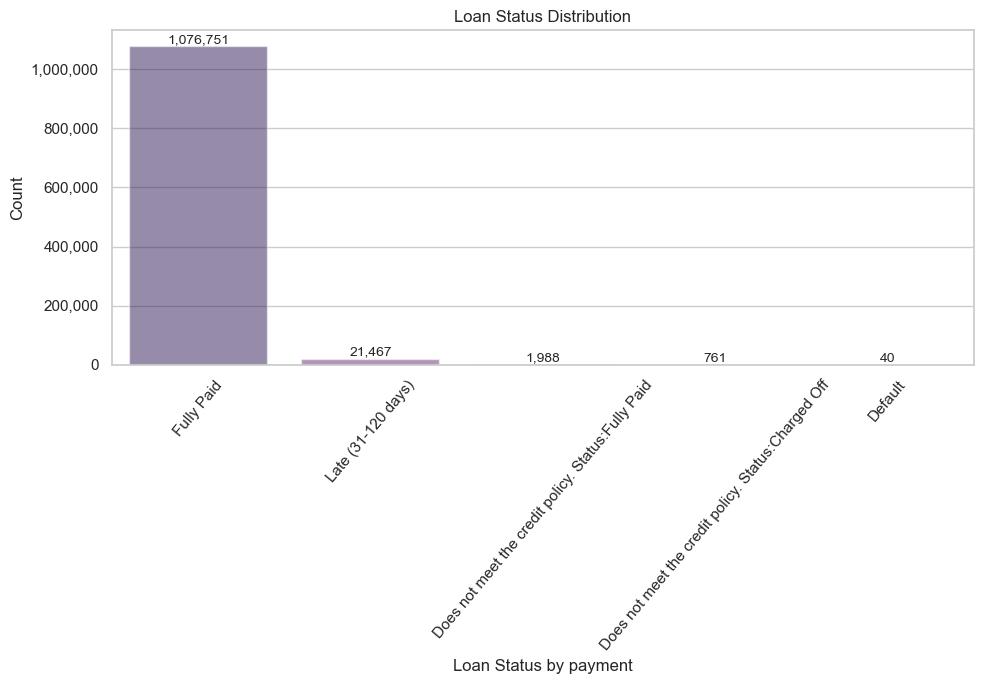

In [51]:

types = df['loan_status'].value_counts()
df1 = types.reset_index()
df1.columns = ['loan_status', 'count']

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='loan_status', y='count', data=df1, palette='magma', ax=ax, alpha = 0.5)

plt.xticks(rotation=50)

def format_func(value, tick_number):
    return f'{int(value):,}'  

for container in ax.containers:
    ax.bar_label(container, labels=[format_func(v, None) for v in container.datavalues], fontsize=10)


ax.yaxis.set_major_formatter(FuncFormatter(format_func))


plt.title("Loan Status Distribution")
plt.xlabel("Loan Status by payment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

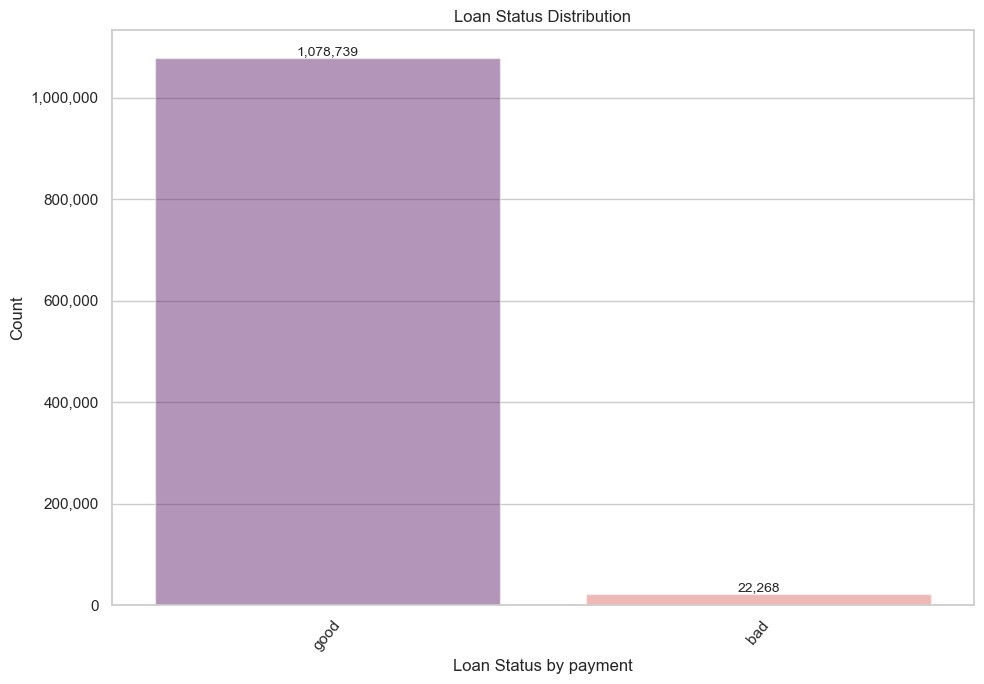

In [52]:
types = df['loan_type'].value_counts()
df1 = types.reset_index()
df1.columns = ['loan_status', 'count']

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x='loan_status', y='count', data=df1, palette='magma', ax=ax, alpha = 0.5)

plt.xticks(rotation=50)

def format_func(value, tick_number):
    return f'{int(value):,}'  
for container in ax.containers:
    ax.bar_label(container, labels=[format_func(v, None) for v in container.datavalues], fontsize=10)

ax.yaxis.set_major_formatter(FuncFormatter(format_func))


plt.title("Loan Status Distribution")
plt.xlabel("Loan Status by payment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

As is clear from these two graphs, we face a problem of highly imbalanced data with the predominance of so called 'good' loans or Fully Paid loans. That is the good news for the financial organization, however, we will need to process the data carefully and take this specificity into account while training our models in future.


<Axes: >

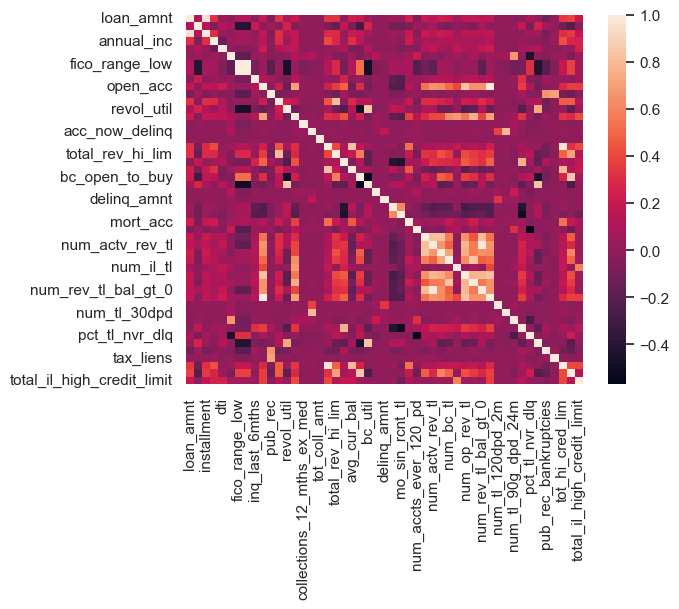

In [53]:
corr = df.corr(numeric_only = True)
sns.heatmap(corr)


Clearly, there are features that correlate with each other strongly. That may provoke the problem of multicollinearity in future, so we need to carefully drop one of the columns that have high value of correlation with other feature. The threshold for such data processing will be 0.8 in absolute values, what can be considered as a very high correlation.

<Axes: >

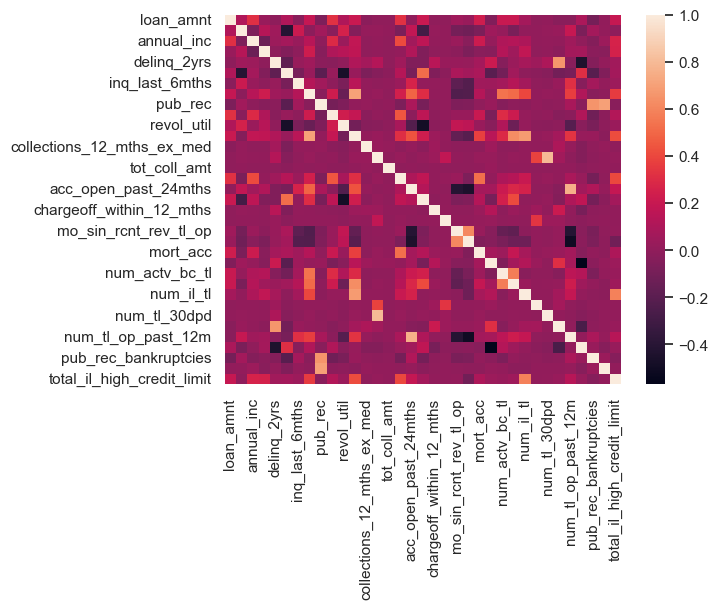

In [54]:
to_drop = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            to_drop.add(corr.columns[i])  # или corr.columns[j]

df_reduced = df.drop(columns=to_drop)
sns.heatmap(df_reduced.corr(numeric_only=True))


Now the correlation matrix shows that there are much less extreme values of correlation between different columns in our dataframe.

In [55]:
df_reduced.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'acc_open_past_24mths', 'bc_open_to_buy',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_bc_tl', 'num_il_tl', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit',
       'loan_type'],
      dtype='object')

### Column Explanation #


* loan_amnt: The total amount of money borrowed by the borrower.

* term: The duration of the loan, expressed in months.

* int_rate: The interest rate applied to the loan, expressed as an annual percentage rate (APR).

* grade: A letter grade assigned to the loan based on the borrower's creditworthiness, often ranging from A (highest quality) to F (lowest quality).

* sub_grade: A more detailed classification of the loan grade, providing finer distinctions within each grade (e.g., A1, A2, B1, etc.).

* emp_title: The job title of the borrower, which may give insights into their employment status and income stability.

* emp_length: The length of time (in years) that the borrower has been employed at their current job.

* home_ownership: The borrower's housing situation, indicating whether they own their home, rent, have a mortgage.

* annual_inc: The annual income of the borrower, which helps assess their ability to repay the loan.

* verification_status: Indicates whether the borrower's income was verified by the lender (e.g., verified, source verified, not verified).

* loan_status: The current status of the loan (e.g., fully paid, charged off, late), indicating whether the borrower has successfully repaid or defaulted on the loan.

* purpose: The reason for taking out the loan (e.g., debt consolidation, home improvement, medical expenses).

* addr_state: The state where the borrower resides, which may influence lending decisions based on regional economic conditions.

* dti: Debt-to-Income ratio, a measure of a borrower's monthly debt payments compared to their monthly income; a lower DTI indicates better financial health.

* delinq_2yrs: The number of delinquencies (late payments) on credit accounts in the past two years.

* earliest_cr_line: The date when the borrower's earliest credit account was opened, providing insight into their credit history length.

* fico_range_low: The lower end of the borrower's FICO credit score range, which is used to assess credit risk.

* inq_last_6mths: The number of inquiries into the borrower's credit report in the last six months; too many inquiries can negatively impact credit scores.

* open_acc: The number of open credit accounts that the borrower currently has.

* pub_rec: The number of public records related to negative financial events (e.g., bankruptcies, tax liens) associated with the borrower.

* revol_bal: The total balance on revolving credit accounts (like credit cards) that the borrower currently owes.

* revol_util: Revolving utilization rate; this is calculated as a percentage and reflects how much credit is being used compared to available credit limits.

* total_acc: The total number of credit accounts that the borrower has opened throughout their credit history.

* collections_12_mths_ex_med: The number of accounts in collections over the past 12 months excluding medical collections.

* acc_now_delinq: The number of accounts that are currently delinquent (overdue).

* tot_coll_amt: Total amount owed on all collections accounts for the borrower.

* tot_cur_bal: Total current balance across all open accounts for the borrower.

* acc_open_past_24mths: Number of accounts opened in the last 24 months; helps assess recent borrowing behavior.

* bc_open_to_buy: Total amount available on all open revolving accounts; indicates how much unused credit is available to a borrower.

* chargeoff_within_12_mths: Number of accounts charged off as uncollectible within the last 12 months.

* delinq_amnt: Total amount overdue across all delinquent accounts.

* mo_sin_rcnt_rev_tl_op: Months since most recent revolving account was opened; shows recent activity in revolving credit accounts.

* mo_sin_rcnt_tl: Months since most recent account opened across all types; provides insight into recent borrowing behavior.

* mort_acc: Number of mortgage accounts currently held by the borrower; relevant for assessing housing-related debt obligations.

* num_accts_ever_120_pd: Total number of accounts that have been 120 days or more past due at any point in time during their history.

* num_actv_bc_tl: Number of active bankcard accounts currently open for use by the borrower.

* num_bc_tl: Total number of bankcard accounts ever opened by the borrower throughout their credit history.

* num_il_tl: Total number of installment loans ever opened by the borrower throughout their credit history (e.g., auto loans, personal loans).

* num_tl_120dpd_2m: Number of tradelines (credit accounts) that have been 120 days past due within the last two months; indicates recent payment issues.

* num_tl_30dpd: Number of tradelines that have been 30 days past due at any point in time during their history; reflects payment reliability over time.

* num_tl_90g_dpd_24m: Number of tradelines that have been 90 days past due at any point in time during last 24 months; indicates significant payment issues recently.

* num_tl_op_past_12m: Number of tradelines opened in last 12 months; provides insight into recent borrowing activity and potential risk factors for lenders.

* pct_tl_nvr_dlq: Percentage of total tradelines that have never been delinquent; higher percentages indicate better repayment behavior and lower risk for lenders.

* pub_rec_bankruptcies: Number of public records related to bankruptcies filed by the borrower; significant negative impact on creditworthiness and lending decisions.

* tax_liens: Number of tax liens against a borrower's property or income; can indicate financial distress and affect lending decisions negatively.

* total_il_high_credit_limit: Total high credit limit across all installment loans held by a borrower; reflects potential borrowing capacity and financial responsibility.

* loan_type: Reliable and unreliable loan indicator.

The last step is to control data leakage. Since we have defaulted loans in the dataset, we need to control that our future models will not see the data that have been collected already after the default. Thus, we need to drop collections_12_mths_ex_med, chargeoff_within_12_mths, since this columns may show that the loan will never be returned.

In [56]:
df_reduced = df_reduced.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'loan_status'], axis = 1)
df_reduced

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,num_il_tl,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,loan_type
0,3600.0,36 months,13.99,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,...,3.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,13734.0,good
1,24700.0,36 months,11.99,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,...,6.0,0.0,0.0,0.0,2.0,97.4,0.0,0.0,24667.0,good
2,20000.0,60 months,10.78,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,...,6.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,14877.0,good
4,10400.0,60 months,22.45,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,...,10.0,0.0,0.0,0.0,4.0,96.6,0.0,0.0,88097.0,good
5,11950.0,36 months,13.44,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,...,2.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,4000.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260684,15000.0,36 months,10.49,B,B3,Billing clerk,8 years,MORTGAGE,60000.0,Not Verified,...,3.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,good
2260686,23800.0,60 months,14.49,C,C4,Exec Dir Internal Audit,10+ years,MORTGAGE,119000.0,Not Verified,...,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,95737.0,good
2260688,18000.0,60 months,9.49,B,B2,NaN,5 years,OWN,130000.0,Not Verified,...,21.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,77756.0,good
2260690,29400.0,60 months,13.99,C,C3,Chief Operating Officer,9 years,MORTGAGE,180792.0,Not Verified,...,17.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,95702.0,good


Let's pass to the non-numeric data exploration. 

In [57]:
object_columns = df_reduced.select_dtypes(include=['object'])
object_columns.dtypes

term                   object
grade                  object
sub_grade              object
emp_title              object
emp_length             object
home_ownership         object
verification_status    object
title                  object
addr_state             object
earliest_cr_line       object
loan_type              object
dtype: object

Let's conduct a comprehensive analysis of our data.

* Term: This consists of both nominal and quantitative data. It can be divided into 2 groups: 30 and 60 months through OHE. 

* Grade: This is classified as ordinal data.

* Sub_Grade: Also categorized as ordinal data.

* Emp_Title: This is nominal data.

* Emp_Length: Although ordinal in nature, we can treat it as quantitative data for analysis.

* Home_Ownership: This is nominal data.

* Verification_Status: Classified as nominal data.

* Purpose: This is nominal data.

* Addr_State: Another example of nominal data.

* Earliest_Cr_Line: This nominal data can be transformed into a more manageable quantitative format.

* Loan_Type: This serves as our target variable.

Furthermore, we will apply one-hot encoding (OHE) to the categorical variables: Grade, Sub_Grade, Addr_State, Term and Verification_Status to prepare them for analysis.

In [58]:

df_reduced['earliest_cr_line'] = pd.to_datetime(df_reduced['earliest_cr_line'], format='%b-%Y') 
sysdate = pd.to_datetime('today')
df_reduced['credit_history'] = (sysdate - df_reduced['earliest_cr_line']).dt.days
df_reduced.drop(columns = 'earliest_cr_line', inplace = True) #getting credit history in days 

In [59]:
df_reduced['verification_status'].unique() #data is messy, let's make it look more neat. Since 'Source Verified' and 'Verified' are actually the same, let's preprocess it.

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [60]:
df_reduced['verification_status'] = df_reduced['verification_status'].apply(lambda x: 'Verified' if x == 'Source Verified' else x)

Text(0.5, 1.0, 'Grade assigned by LC')

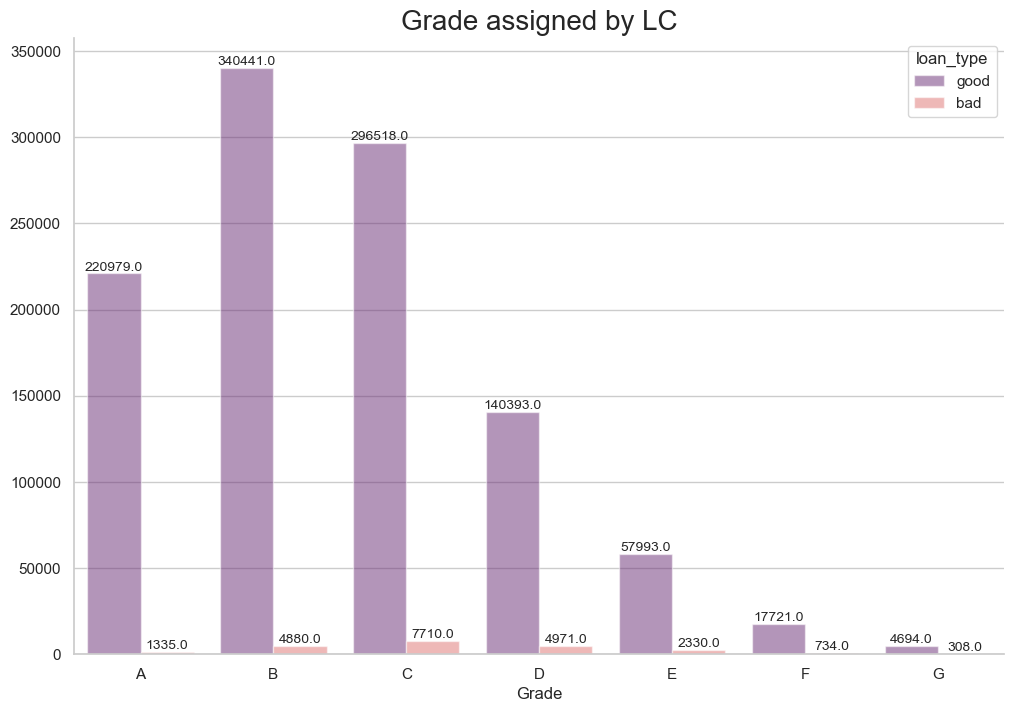

In [61]:
fig, ax =plt.subplots(figsize=(12,8)) 
sns.despine()
order=sorted(df_reduced["grade"].unique())
sns.countplot(data=df_reduced,x="grade",hue="loan_type",order=order, palette = 'magma', alpha = 0.5)
for container in ax.containers:
    ax.bar_label(container, labels= container.datavalues, fontsize=10)

ax.tick_params(axis='x', labelrotation=0)
ax.set(xlabel='Grade', ylabel='')
ax.set_title('Grade assigned by LC', size=20)

As the loan grade worsens from A to G, the proportion of bad loans increases (as it was expected). This trend can be used in predictive modeling to assess the likelihood of defaults based on loan grade.
The majority of loans are concentrated in the A to C grades, with fewer loans allocated to the riskier grades D through G.
There is a noticeable risk increase from Grade C onwards, which might be important for understanding cut-off points when determining acceptable loan risk thresholds.

In [62]:
good_loan_types = ["good"]  
bad_loan_types = ["bad"]    

map_good_loans = df[df["loan_type"].isin(good_loan_types)]
map_bad_loans = df[df["loan_type"].isin(bad_loan_types)]


m_good = map_good_loans[["addr_state", "loan_type"]]
m_good = m_good.groupby("addr_state")["loan_type"].agg('count').reset_index(name='count')

m_bad = map_bad_loans[["addr_state", "loan_type"]]
m_bad = m_bad.groupby("addr_state")["loan_type"].agg('count').reset_index(name='count')

total_good_loans = m_good['count'].sum()
total_bad_loans = m_bad['count'].sum()

m_good['percentage'] = (m_good['count'] / total_good_loans) * 100
m_bad['percentage'] = (m_bad['count'] / total_bad_loans) * 100


fig_good = go.Figure(data=go.Choropleth(
    locations=m_good["addr_state"], 
    z=m_good["percentage"],  
    locationmode='USA-states',  
    colorscale='blues',
    colorbar_title="Good Loans (%)",
))

fig_good.update_layout(
    title_text='Percentage of Good Loans by State (2008-2018)',
    geo_scope='usa', 
)


fig_bad = go.Figure(data=go.Choropleth(
    locations=m_bad["addr_state"],  
    z=m_bad["percentage"],  
    locationmode='USA-states',  
    colorscale='reds',
    colorbar_title="Bad Loans (%)",
))

fig_bad.update_layout(
    title_text='Percentage of Bad Loans by State (2008-2018)',
    geo_scope='usa',  
)


fig_good.show()
fig_bad.show()

Both graphs highlight that California, Texas, Florida, and New York are the top four regions with the highest outstanding loan amounts. These states account for the largest loan volumes, which naturally leads to a higher proportion of both good and bad loans. This reflects their significant share of overall lending activity.

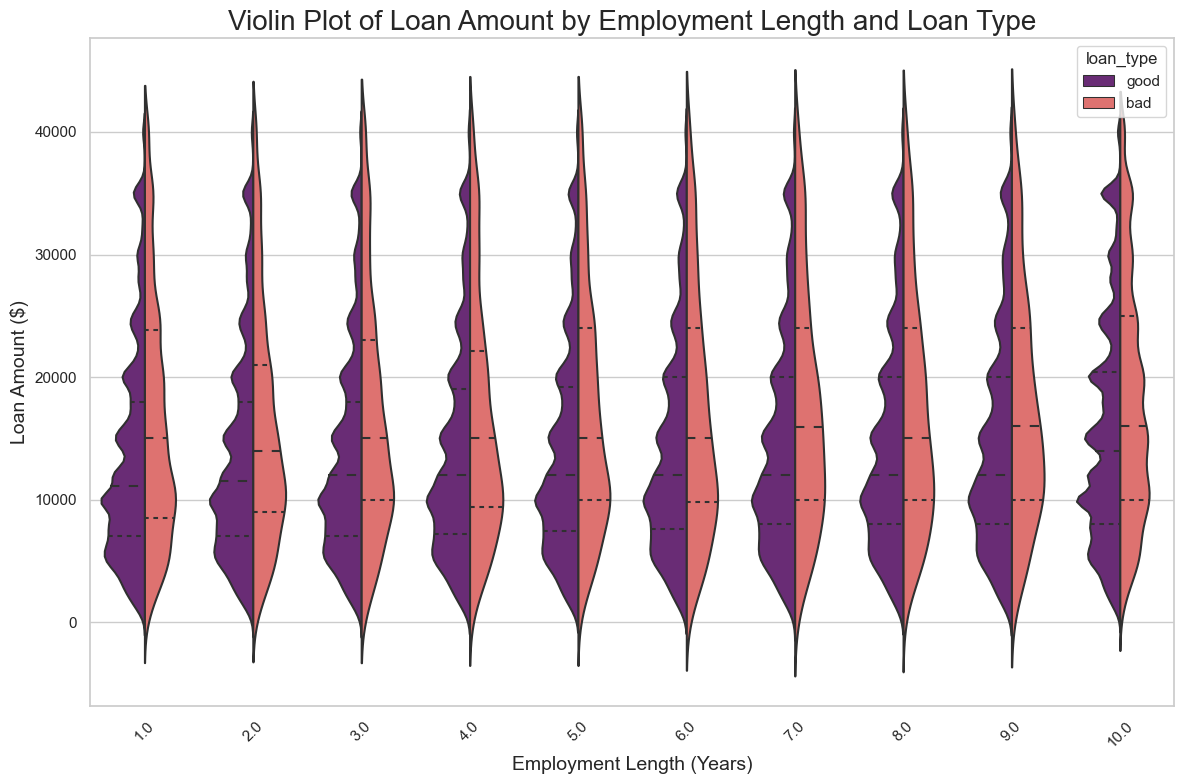

In [63]:
df_reduced['emp_length_num'] = df_reduced['emp_length'].str.extract('(\d+)').astype(float)


plt.figure(figsize=(12, 8))


sns.violinplot(data=df_reduced, x='emp_length_num', y='loan_amnt', hue='loan_type',
                split=True, palette='magma', inner='quartile', alpha = 0.5)


plt.title('Violin Plot of Loan Amount by Employment Length and Loan Type', size=20)
plt.xlabel('Employment Length (Years)', size=14)
plt.ylabel('Loan Amount ($)', size=14)
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

There is a slight rightward skew in the distribution of both good and bad loans for longer employment tenures, suggesting that individuals with more years of employment tend to take larger loans on average.

For shorter employment lengths (1-3 years), the distributions of bad loans seem more pronounced, possibly indicating that individuals with shorter employment histories might be riskier borrowers, as evidenced by the higher concentration of bad loans.

As employment length increases beyond 5 years, good loans show a larger distribution spread, indicating more reliable borrowers who are approved for higher loan amounts. However, bad loans remain present but in smaller quantities.

The violin plots highlight that the majority of loan amounts, whether good or bad, tend to cluster between 10,000   and 20,000, with fewer loans exceeding $40,000.
The shape of the distribution also suggests that bad loans tend to exhibit less variability in loan amount, while good loans have a wider spread, especially at higher amounts.




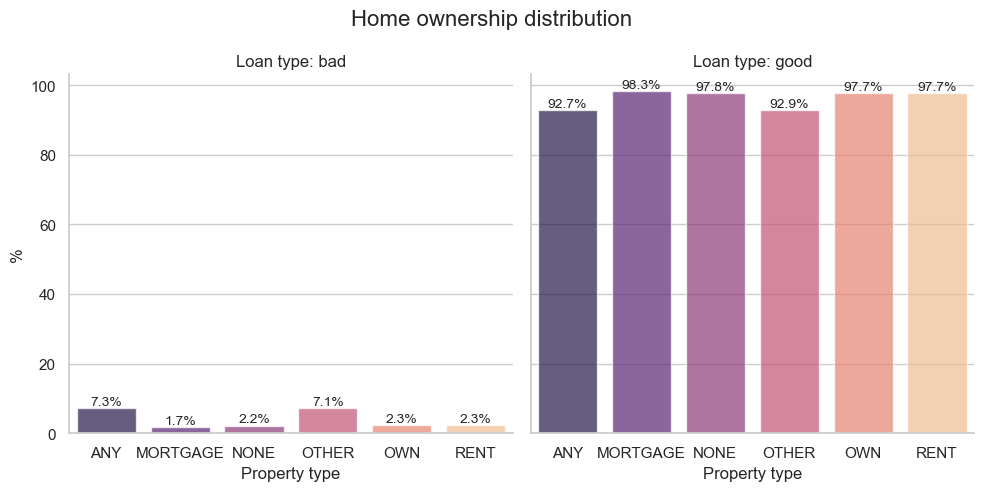

In [64]:

counts = df.groupby(['home_ownership', 'loan_type']).size().reset_index(name='count')

total_counts = counts.groupby('home_ownership')['count'].transform('sum')
counts['percentage'] = counts['count'] / total_counts * 100

g = sns.FacetGrid(counts, col='loan_type', col_wrap=2, height=5, aspect=1)
g.map_dataframe(sns.barplot, x='home_ownership', y='percentage', palette='magma', alpha=0.7)

g.set_axis_labels('Property type', '%')
g.set_titles(col_template='Loan type: {col_name}')
g.fig.suptitle('Home ownership distribution', fontsize=16)
g.fig.subplots_adjust(top=0.85) 

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=10)

plt.show()

There is a clear contrast between the "MORTGAGE" category, where a much larger percentage of loans are good (98.3%), versus bad (1.7%). This indicates that owning a property with a mortgage could be an indicator of creditworthiness, while 'OTHER' (maybe living in a dormitory or with parents) and 'ANY' may show low trustworthingness. 

In [65]:
df = pd.get_dummies(df_reduced, columns=['grade', 'verification_status', 'addr_state', 'sub_grade', 'home_ownership', 'term'], prefix=['grade', 'verification_status', 'addr_state', 'sub_grade', 'home_ownership', 'term'], drop_first=True)

In [66]:
df

,loan_amnt,int_rate,emp_title,emp_length,annual_inc,title,dti,delinq_2yrs,fico_range_low,inq_last_6mths,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,term_ 60 months
0,3600.0,13.99,leadman,10+ years,55000.0,Debt consolidation,5.91,0.0,675.0,1.0,...,False,False,False,False,True,False,False,False,False,False
1,24700.0,11.99,Engineer,10+ years,65000.0,Business,16.06,1.0,715.0,4.0,...,False,False,False,False,True,False,False,False,False,False
2,20000.0,10.78,truck driver,10+ years,63000.0,NaN,10.78,0.0,695.0,0.0,...,False,False,False,False,True,False,False,False,False,True
4,10400.0,22.45,Contract Specialist,3 years,104433.0,Major purchase,25.37,1.0,695.0,3.0,...,False,False,False,False,True,False,False,False,False,True
5,11950.0,13.44,Veterinary Tecnician,4 years,34000.0,Debt consolidation,10.20,0.0,690.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260684,15000.0,10.49,Billing clerk,8 years,60000.0,Debt consolidation,26.40,0.0,680.0,0.0,...,False,False,False,False,True,False,False,False,False,False
2260686,23800.0,14.49,Exec Dir Internal Audit,10+ years,119000.0,Debt consolidation,32.73,0.0,685.0,1.0,...,False,False,False,False,True,False,False,False,False,True
2260688,18000.0,9.49,NaN,5 years,130000.0,Home improvement,20.59,0.0,735.0,1.0,...,False,False,False,False,False,False,False,True,False,True
2260690,29400.0,13.99,Chief Operating Officer,9 years,180792.0,Debt consolidation,22.03,0.0,705.0,1.0,...,False,False,False,False,True,False,False,False,False,True


## Data cleaning 

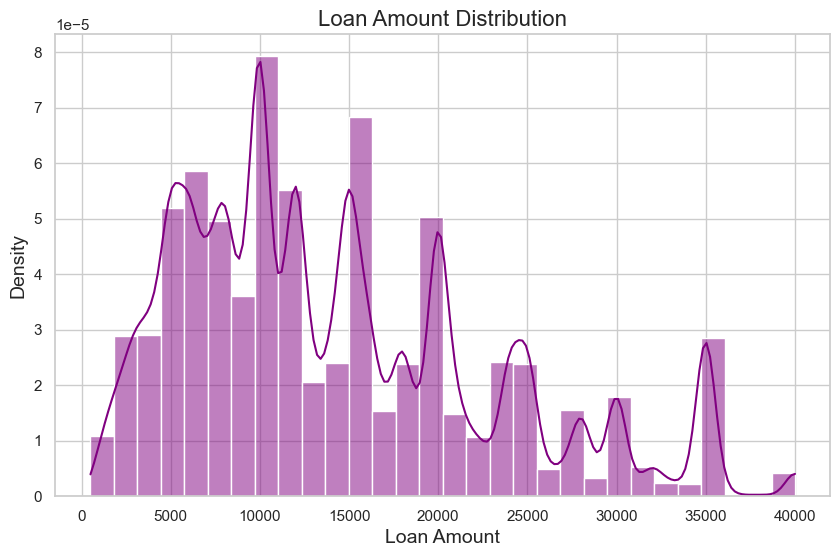

In [67]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", palette="magma")
sns.histplot(df['loan_amnt'], bins=30, kde=True, color='purple', stat='density', alpha=0.5)

plt.title('Loan Amount Distribution', fontsize=16)
plt.xlabel('Loan Amount', fontsize=14)
plt.ylabel('Density', fontsize=14)


plt.show()

The KDE overlay indicates that the distribution is multimodal, meaning there are multiple peaks or modes in the data. This suggests that loan amounts might cluster around different values (e.g., 10,000, 15,000, 20,000, 35,000). These peaks could represent different types of loans, customer segments, or lending policies.

From a statistical standpoint, the data does not follow a normal distribution, given the asymmetric shape and multimodality. Therefore, using summary statistics like mean and standard deviation might not fully capture the characteristics of the dataset. 

Let's clear each quantative parameter from outliers.

In [68]:
len(df.columns)

136

<Figure size 2000x1000 with 0 Axes>

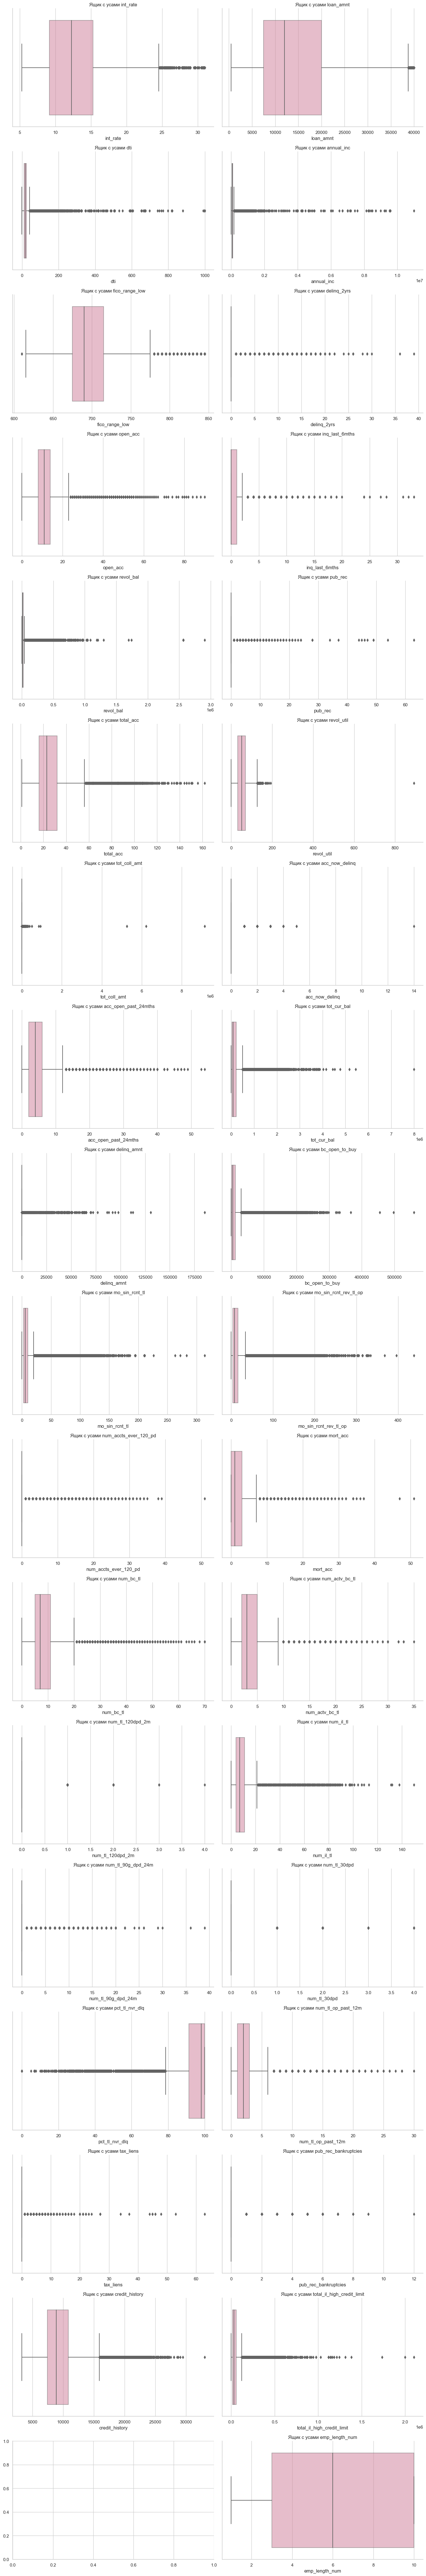

In [69]:
plt.figure(figsize=(20, 10))

numeric_columns = df.select_dtypes(include='number').columns

# Определяем количество строк и столбцов для подграфиков
num_vars = len(numeric_columns)
num_rows = (num_vars // 2) + (num_vars % 2 > 0)  # По два графика в строке

fig, ax = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
sns.set_style("whitegrid")

for i in range(num_vars):

    sns.boxplot(x=df[numeric_columns[i]], ax=ax[i // 2][(i % 2) + 1] if (i % 2) == 0 else ax[i // 2][0], color='#DB7093', boxprops=dict(alpha=0.5))
    ax[i // 2][(i % 2) + (1 if (i % 2) == 0 else -1)].set_title(f'Ящик с усами {numeric_columns[i]}')
sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

As evident from the box plot, we observe a significant number of outliers across various categories. However, I firmly believe that simply removing all outliers indiscriminately is not a viable approach, as it would result in the loss of valuable data. This concern was confirmed through testing—blanket removal of outliers led to the exclusion of hundreds of thousands of observations, which is entirely unacceptable.

Moreover, iterative 3-sigma cleaning has proven ineffective in addressing the issue. Instead, I suggest employing IQR-based cleaning, which would not only help us identify outliers but also allow us to use this information to distinguish between different types of agents taking out loans. This method should preserve important data while offering deeper insights.

In [70]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df[numeric_df['dti'] >= 0]
df = df[df['dti'] >= 0]
#there's a mistake with 2 negative lines

I propose that we focus on exploring the columns with a high proportion of outliers. This could provide us with deeper insights into the underlying data distribution and help us better understand its structure.

In [71]:
def calculate_outlier_fraction(numeric_df):
    outlier_fractions = {}
    
    for column in numeric_df.columns:

        q1 = numeric_df[column].quantile(0.25)
        q3 = numeric_df[column].quantile(0.75)
        iqr = q3 - q1
        
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers_count = ((numeric_df[column] < lower_bound) | (numeric_df[column] > upper_bound)).sum()
        
        fraction = outliers_count / len(numeric_df)
        outlier_fractions[column] = fraction
    
    return outlier_fractions

outlier_fractions = calculate_outlier_fraction(numeric_df)

for column, fraction in outlier_fractions.items():
    print(f'Outliers fraction "{column}": {fraction:.2%}')

Outliers fraction "loan_amnt": 0.55%
Outliers fraction "int_rate": 1.77%
Outliers fraction "annual_inc": 4.65%
Outliers fraction "dti": 0.42%
Outliers fraction "delinq_2yrs": 18.95%
Outliers fraction "fico_range_low": 3.27%
Outliers fraction "inq_last_6mths": 5.02%
Outliers fraction "open_acc": 3.30%
Outliers fraction "pub_rec": 16.38%
Outliers fraction "revol_bal": 6.03%
Outliers fraction "revol_util": 0.00%
Outliers fraction "total_acc": 1.67%
Outliers fraction "acc_now_delinq": 0.46%
Outliers fraction "tot_coll_amt": 14.17%
Outliers fraction "tot_cur_bal": 3.12%
Outliers fraction "acc_open_past_24mths": 1.97%
Outliers fraction "bc_open_to_buy": 8.11%
Outliers fraction "delinq_amnt": 0.36%
Outliers fraction "mo_sin_rcnt_rev_tl_op": 7.72%
Outliers fraction "mo_sin_rcnt_tl": 6.07%
Outliers fraction "mort_acc": 1.42%
Outliers fraction "num_accts_ever_120_pd": 22.03%
Outliers fraction "num_actv_bc_tl": 1.85%
Outliers fraction "num_bc_tl": 2.01%
Outliers fraction "num_il_tl": 5.69%
Outlie

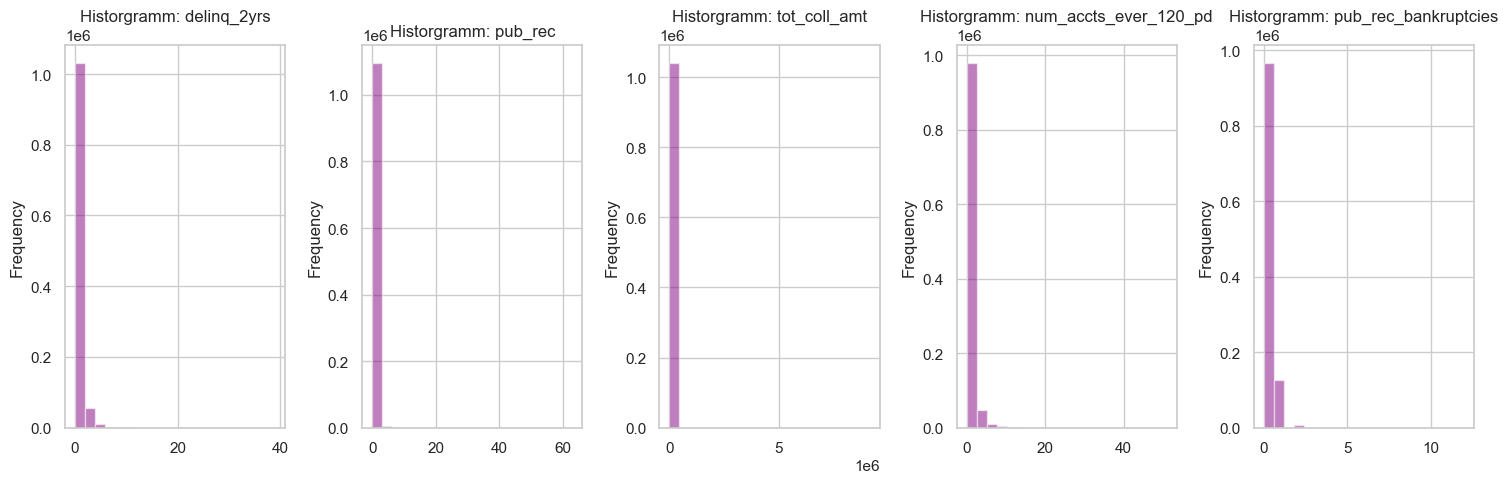

In [72]:
columns_with_outliers = [column for column, fraction in outlier_fractions.items() if fraction > 0.10]

plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_with_outliers):
    plt.subplot(1, len(columns_with_outliers), i + 1)
    plt.hist(df[column], bins=20, color='purple', alpha = 0.5)
    plt.title(f'Historgramm: {column}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The data doesn't fit any standard distribution. In fact, a T-test for the Poisson distribution confirmed that it cannot be modeled as a Poisson with 1 degree of freedom. Given this, I suggest we try scaling the data using logarithmic transformation to achieve a more manageable distribution.

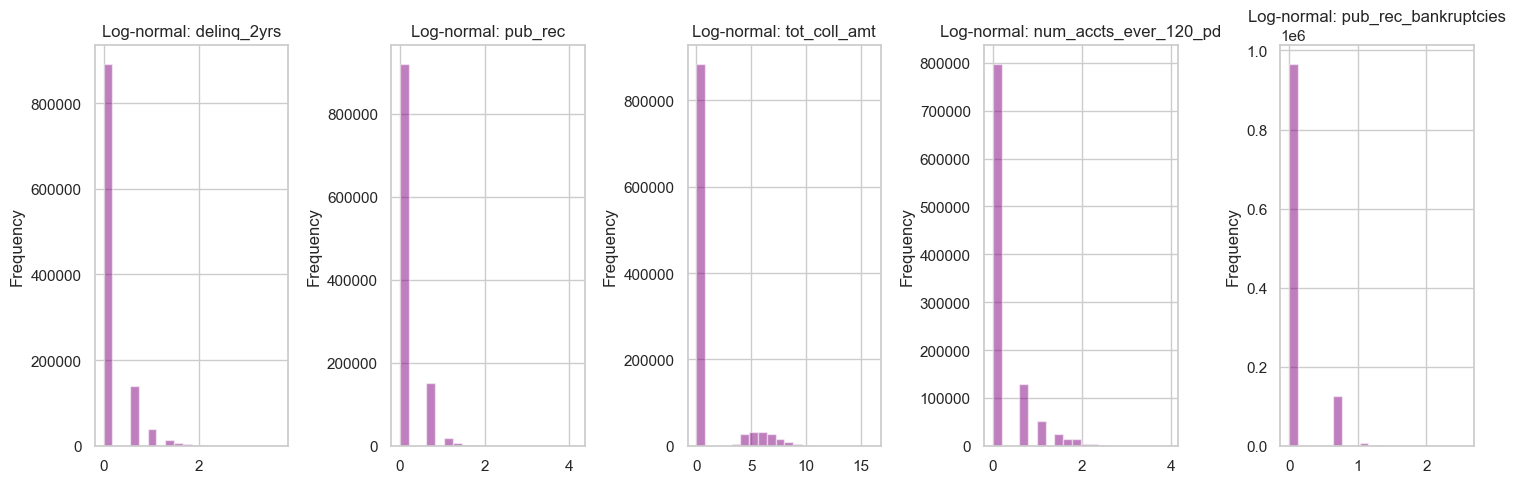

In [73]:
df_log = numeric_df.copy()
for column in columns_with_outliers:
    df_log[column] = np.log1p(numeric_df[column]) 

plt.figure(figsize=(15, 5))
for i, column in enumerate(columns_with_outliers):
    plt.subplot(1, len(columns_with_outliers), i + 1)
    plt.hist(df_log[column], bins=20, color = 'purple', alpha = 0.5)
    plt.title(f'Log-normal: {column}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Unfortunately, this graph itself cannot provide us with some new knowledge about groups ditribution. It appears we need to delve deeper into the group distributions to gain a clearer understanding.

In [74]:
def find_outliers_iqr_by_status(df, column, status_column='loan_type', bad_status='bad', good_status='good'):

    bad_loans = df[df[status_column] == bad_status]
    good_loans = df[df[status_column] == good_status]
    
    def find_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        return outliers

    bad_outliers = find_outliers_iqr(bad_loans, column)
    good_outliers = find_outliers_iqr(good_loans, column)
    
    bad_stats = bad_outliers[column].describe()
    good_stats = good_outliers[column].describe()
    
    print("\nOutliers statistics for bad loans:")
    print(bad_stats)
    print("\nOutliers statistics for good loans:")
    print(good_stats)
    

    return bad_outliers, good_outliers, bad_stats, good_stats

for column in columns_with_outliers:
    bad_outliers, good_outliers, bad_stats, good_stats = find_outliers_iqr_by_status(df, column)
    

    print(f"СOutliers statistics for bad loans({column}):")
    print(bad_stats)
    print(f"Outliers statistics for good loans ({column}):")
    print(good_stats)





Outliers statistics for bad loans:
count    4654.000000
mean        1.689300
std         1.461794
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        36.000000
Name: delinq_2yrs, dtype: float64

Outliers statistics for good loans:
count    203897.000000
mean          1.635453
std           1.327312
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          39.000000
Name: delinq_2yrs, dtype: float64
СOutliers statistics for bad loans(delinq_2yrs):
count    4654.000000
mean        1.689300
std         1.461794
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        36.000000
Name: delinq_2yrs, dtype: float64
Outliers statistics for good loans (delinq_2yrs):
count    203897.000000
mean          1.635453
std           1.327312
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          39.000000
Name: delinq_2yrs, dty

And here we got some crucial ideas:

Similar Outlier Distributions in Certain Columns: In columns such as delinq_2yrs, pub_rec, and pub_rec_bankruptcies, the outlier distributions for bad and good loans appear relatively similar. This may indicate that these factors affect all borrower categories, but are interpreted differently depending on other risk factors.

Significant Differences in Some Columns: In columns like tot_coll_amt and num_accts_ever_120_pd, there are more pronounced differences between good and bad loans. This suggests that a high number of delinquencies and collection amounts are more frequently associated with borrowers with poor credit histories, as reflected in the outliers.

Rare Exceptions Among Good Loans: The good loans group also contains outliers with extremely high values (e.g., in terms of collection amounts or the number of delinquent accounts), which may indicate rare cases of borrowers with significant financial issues who are still considered good clients based on other factors.



In [75]:
diff_col = ['tot_coll_amt', 'num_accts_ever_120_pd'] #these columns will be used for groups distinguishing
for column in diff_col:
    bad_outliers, good_outliers, bad_stats, good_stats = find_outliers_iqr_by_status(df, column)


Outliers statistics for bad loans:
count      3727.000000
mean       1342.960826
std        4410.723455
min          23.000000
25%         153.000000
50%         415.000000
75%        1148.500000
max      197765.000000
Name: tot_coll_amt, dtype: float64

Outliers statistics for good loans:
count    1.522170e+05
mean     1.681155e+03
std      3.186371e+04
min      2.000000e+00
25%      1.450000e+02
50%      3.840000e+02
75%      1.116000e+03
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

Outliers statistics for bad loans:
count    1453.000000
mean        4.889195
std         2.859323
min         3.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        34.000000
Name: num_accts_ever_120_pd, dtype: float64

Outliers statistics for good loans:
count    236888.000000
mean          2.162891
std           1.979012
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: num_accts_ever_120_pd,

In [76]:
#other groups we will clear from outliers

def remove_outliers_iqr_by_status(df, columns, status_column='loan_type', bad_status='bad', good_status='good'):
    def calculate_iqr_bounds(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return lower_bound, upper_bound

    for column in columns:
        bad_loans = df[df[status_column] == bad_status]
        good_loans = df[df[status_column] == good_status]
        bad_lower, bad_upper = calculate_iqr_bounds(bad_loans, column)
        good_lower, good_upper = calculate_iqr_bounds(good_loans, column)
        

        df = df[
            ((df[status_column] == bad_status) & (df[column] >= bad_lower) & (df[column] <= bad_upper)) |
            ((df[status_column] == good_status) & (df[column] >= good_lower) & (df[column] <= good_upper))
        ]
    
    return df

columns_with_outliers = ['delinq_2yrs', 'pub_rec','pub_rec_bankruptcies']

cleaned_df = remove_outliers_iqr_by_status(df, columns_with_outliers)


I noticed that certain outliers were strongly correlated with those in other groups. By removing these outliers from specific columns, we were able to simultaneously eliminate outliers in other related columns, streamlining the data cleaning process.

In [77]:
print(cleaned_df['delinq_2yrs'].value_counts())
print(cleaned_df['pub_rec'].value_counts())
print(cleaned_df['num_tl_120dpd_2m'].value_counts())
print(cleaned_df['acc_now_delinq'].value_counts())
print(cleaned_df['num_tl_30dpd'].value_counts())
print(cleaned_df['num_tl_90g_dpd_24m'].value_counts())
print(cleaned_df['pub_rec_bankruptcies'].value_counts())
print(cleaned_df['tax_liens'].value_counts())



delinq_2yrs
0.0    738557
Name: count, dtype: int64
pub_rec
0.0    738557
Name: count, dtype: int64
num_tl_120dpd_2m
0.0    670154
Name: count, dtype: int64
acc_now_delinq
0.0    738557
Name: count, dtype: int64
num_tl_30dpd
0.0    688269
Name: count, dtype: int64
num_tl_90g_dpd_24m
0.0    688269
Name: count, dtype: int64
pub_rec_bankruptcies
0.0    738557
Name: count, dtype: int64
tax_liens
0.0    738557
Name: count, dtype: int64


In [78]:
cleaned_df[cleaned_df['loan_type'] == 'bad']['delinq_amnt'].value_counts() #checking one specific group for common sense sake

delinq_amnt
0.0    13968
Name: count, dtype: int64

In [79]:
cleaned_df = cleaned_df.drop(columns = ['num_tl_120dpd_2m','acc_now_delinq', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'delinq_amnt', 'pub_rec', 'delinq_2yrs'] )

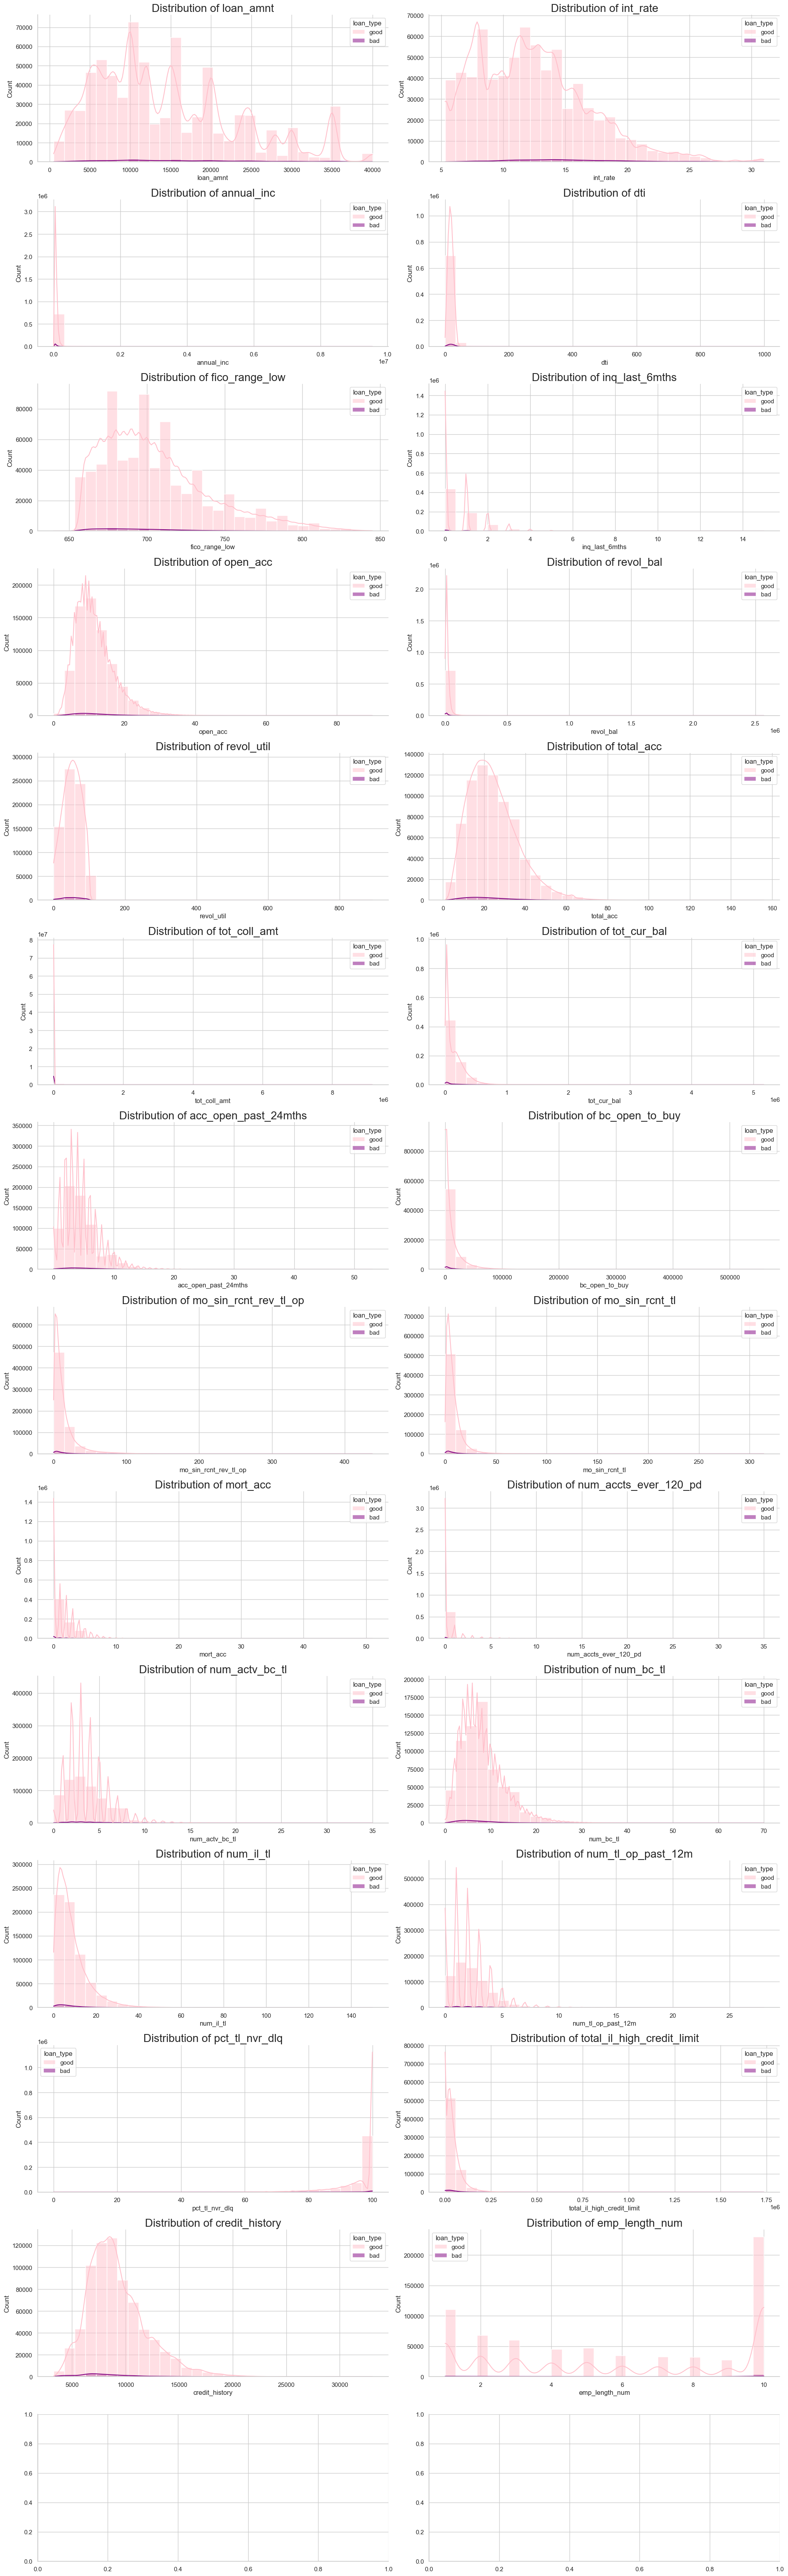

In [80]:
n = len(cleaned_df.select_dtypes(include='number').columns.tolist())
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, ax = plt.subplots(nrows=nrows + 1, ncols=ncols, figsize=(20, nrows * 5))
palette = {"good": "pink", "bad": "purple"} 
sns.despine()

for i, column in enumerate(cleaned_df.select_dtypes(include='number').columns.tolist()):

    row = i // ncols
    col = i % ncols
    

    ax[row, col].tick_params(axis='x', labelrotation=0)
    ax[row, col].set(xlabel=column, ylabel='')
    ax[row, col].set_title(f'Distribution of {column}', size=20)
    

    sns.histplot(data=cleaned_df, x=column, hue="loan_type", bins=30,
                 kde=True, ax=ax[row, col], palette = palette)

for j in range(i + 1, nrows * ncols):
    if j < nrows * ncols:  
        fig.delaxes(ax[j // ncols][j % ncols])

plt.tight_layout()
plt.show()


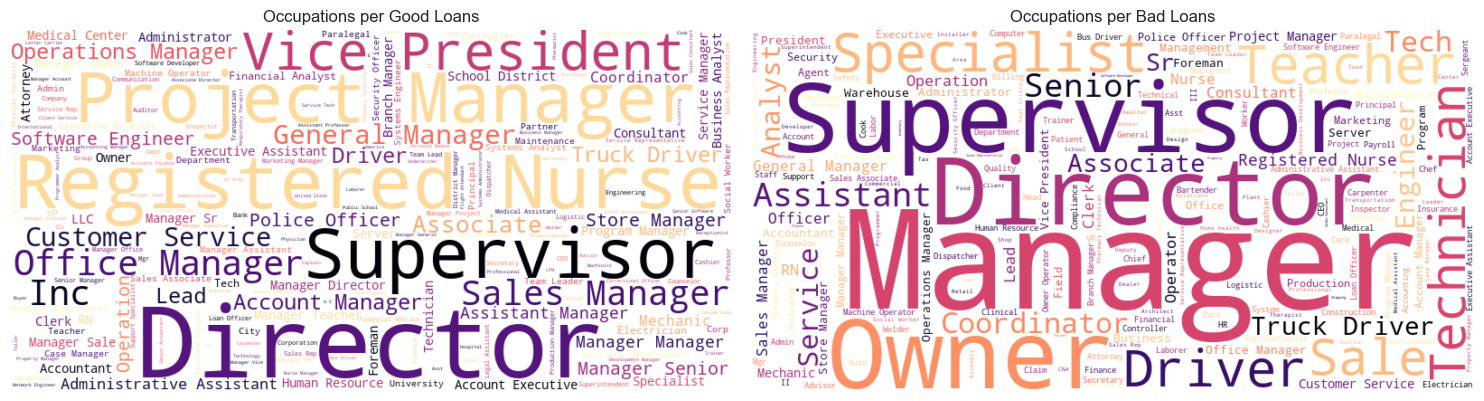

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

good_loans = cleaned_df[cleaned_df["loan_type"] == "good"]
bad_loans = cleaned_df[cleaned_df["loan_type"] == "bad"]


good_professions_text = ' '.join(good_loans['emp_title'].dropna())
bad_professions_text = ' '.join(bad_loans['emp_title'].dropna())

wordcloud_good = WordCloud(width=800, height=400, background_color='white', colormap = 'magma').generate(good_professions_text)
wordcloud_bad = WordCloud(width=800, height=400, background_color='white', colormap = 'magma').generate(bad_professions_text)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.title('Occupations per Good Loans')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Occupations per Bad Loans')

plt.tight_layout()
plt.show()

Certain occupations are more prominent in the good loans category, such as Vice President, Sales Manager, and Registered Nurse. These could be indicative of more financially stable or higher-earning professions, which correlates with a better loan performance.
On the other hand, occupations like Driver, Technician, and Owner are more dominant in the bad loans category, potentially indicating that individuals in these roles might face higher financial risks or variability in income, leading to worse credit outcomes.


In [82]:
cleaned_df.to_csv('processed_data.csv')